
# Step 1: Clone the CORIA library code from Github repository

Clone repository from Github:

In [1]:
import os
if os.getcwd().endswith("/py-coria-notebook"):    
    !echo "Switching current working directory from: ${PWD}"    
    os.chdir('..')
    !echo "To: ${PWD}" 

# Check if the coria library repository directory exists. If it does, we remove it
![ -d "./py-coria-notebook" ] && rm -rf ./py-coria-notebook

# Now we can download the coria library repository
!git clone https://github.com/df8/py-coria-notebook.git

Cloning into 'py-coria-notebook'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 54 (delta 24), reused 47 (delta 20), pack-reused 0
Unpacking objects: 100% (54/54), done.


Switch working directory:

In [2]:
if not os.getcwd().endswith("/py-coria-notebook"):    
    !echo "Switching current working directory from: ${PWD}"    
    os.chdir('./py-coria-notebook')
    !echo "To: ${PWD}"    
else:
    print("Current working directory:" + os.getcwd())

Switching current working directory from: /jupyterhub-homes/2037
To: /jupyterhub-homes/2037/py-coria-notebook



# Step 2: Import coria_lib functions

`CORIA_METRIC_TREE` = a dictionary with metric algorithms, metric variants and references to all functions

`CORIA_METRIC_DEPENDENCIES` = a dictionary which we use to look up dependencies (see function collect_dependencies_recursive() in step 5 below)

In [3]:
from coria_lib.coria_config import set_global_settings, coria_imports

set_global_settings(use_cuda=True)
coria_imports()
from coria_lib.coria_dependencies import CORIA_METRIC_TREE, collect_dependencies_recursive
from coria_lib.coria_helper_functions import log

print("Successfully imported coria_lib. Metric algorithms available: " + str(len(CORIA_METRIC_TREE)))

Using Architecture: GPU-accelerated
Successfully imported coria_lib. Metric algorithms available: 18



# Step 3: Import the Dataset

For the example we are using a simple graph with 9 nodes and 14 edges.

`input_dataframe_dict` = a dictionary that holds multiple representations of the dataset: as a graph object and as a dataframe of edges

In [4]:
from coria_lib.coria_config import pd, cugraph
from coria_lib.coria_results import set_input_dataframe_dict

input_dataframe_dict = {}
filepath = './datasets/mclaughlin_bader_9nodes_14edges.txt'
input_dataframe_dict['edges'] = pd.read_csv(filepath, delimiter='\t', names=['node_source', 'node_target'])
input_dataframe_dict['graph'] = cugraph.Graph()
input_dataframe_dict['graph'].from_cudf_edgelist(input_dataframe_dict['edges'], source='node_source', destination='node_target')
set_input_dataframe_dict(input_dataframe_dict)


## Visualize the Network Graph


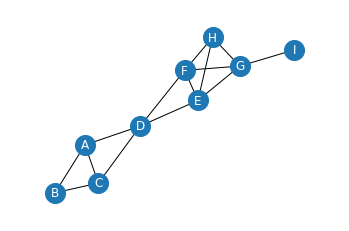

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
g = nx.from_pandas_edgelist(input_dataframe_dict['edges'].to_pandas(), source='node_source', target='node_target')
pos = nx.drawing.layout.spring_layout(g, seed=9)
nx.draw_networkx(g, pos, node_size=400, font_color='white')
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()



# Step 4: See which metrics are available

In [6]:
for metric_algorithm_id in CORIA_METRIC_TREE:
    print('\n' + metric_algorithm_id)
    for metric_variant_id in CORIA_METRIC_TREE[metric_algorithm_id]:
        print('\t' + metric_variant_id)



node-degree
	node-degree--default
	node-degree--normalised

shortest-path-lengths
	shortest-path-lengths--default

average-shortest-path-length
	average-shortest-path-length--default
	average-shortest-path-length--normalised

eccentricity
	eccentricity--default
	eccentricity--normalised

betweenness-centrality
	betweenness-centrality--default
	betweenness-centrality--normalised

average-neighbour-degree
	average-neighbour-degree--default
	average-neighbour-degree--corrected
	average-neighbour-degree--corrected-and-normalised

iterated-average-neighbour-degree
	iterated-average-neighbour-degree--default
	iterated-average-neighbour-degree--corrected
	iterated-average-neighbour-degree--corrected-and-normalised

local-clustering-coefficients
	local-clustering-coefficients--default
	local-clustering-coefficients--corrected
	local-clustering-coefficients--corrected-and-normalised

unified-risk-score
	unified-risk-score--default

connectivity-risk-classification
	connectivity-risk-classifica

# Step 5: Prepare the Execution Plan

In [7]:
from coria_lib.coria_results import input_dataframe_dict
from coria_lib.coria_parse_args import set_metric_parameters

metric_to_compute = 'connectivity-risk-classification--default'
set_metric_parameters(metric_to_compute, 'threshold-low', 0.45)
set_metric_parameters(metric_to_compute, 'threshold-high', 0.55)
# Prepare the execution queue based on the dependencies
execution_queue = collect_dependencies_recursive(metric_to_compute)

print("##############################")
print("####    Execution Plan    ####")
print("##############################\n")
for i in range(len(execution_queue)):
    print(str(i + 1) + ".\t" + execution_queue[i])


##############################
####    Execution Plan    ####
##############################

1.	node-degree--default
2.	node-degree--normalised
3.	average-neighbour-degree--corrected
4.	average-neighbour-degree--corrected-and-normalised
5.	shortest-path-lengths--default
6.	iterated-average-neighbour-degree--corrected
7.	iterated-average-neighbour-degree--corrected-and-normalised
8.	betweenness-centrality--default
9.	betweenness-centrality--normalised
10.	eccentricity--default
11.	eccentricity--normalised
12.	average-shortest-path-length--default
13.	average-shortest-path-length--normalised
14.	unified-risk-score--default
15.	local-clustering-coefficients--default
16.	local-clustering-coefficients--corrected
17.	local-clustering-coefficients--corrected-and-normalised
18.	connectivity-risk-classification--default


# Step 6: Compute the Connectivity Risk Classification


In [8]:
from coria_lib.coria_execute import execute_metrics

execute_metrics(execution_queue)
log("Computation of " + metric_to_compute + " completed.")

2020-11-12 09:27:29 Starting execution of node-degree--default
2020-11-12 09:27:29 Starting execution of node-degree--normalised
2020-11-12 09:27:29 Starting execution of average-neighbour-degree--corrected
2020-11-12 09:27:29 Starting execution of average-neighbour-degree--corrected-and-normalised
2020-11-12 09:27:30 Starting execution of shortest-path-lengths--default
2020-11-12 09:27:30 Skipped execution of iterated-average-neighbour-degree--corrected: Metric has already been computed
2020-11-12 09:27:30 Starting execution of iterated-average-neighbour-degree--corrected-and-normalised
2020-11-12 09:27:30 Starting execution of betweenness-centrality--default
2020-11-12 09:27:30 Starting execution of betweenness-centrality--normalised
2020-11-12 09:27:30 Skipped execution of eccentricity--default: Metric has already been computed
2020-11-12 09:27:30 Starting execution of eccentricity--normalised
2020-11-12 09:27:30 Skipped execution of average-shortest-path-length--default: Metric has


# Step 7: Print the Results

In [9]:
# The table is very wide: 18 columns, therefore we divide it into three equal pieces and print 7 columns at a time
from IPython.display import display

input_dataframe_dict['nmr-dependencies'] = input_dataframe_dict['nmr-dependencies'].sort_values('node_source')

display(input_dataframe_dict['nmr-dependencies'].iloc[:, [0, 1, 2, 3, 4, 5, 6]])
display(input_dataframe_dict['nmr-dependencies'].iloc[:, [0, 7, 8, 9, 10, 11, 12]])
display(input_dataframe_dict['nmr-dependencies'].iloc[:, [0, 13, 14, 15, 16, 17]])


,node_source,node-degree--default,node-degree--normalised,average-neighbour-degree--corrected,average-neighbour-degree--corrected-and-normalised,iterated-average-neighbour-degree--corrected,eccentricity--default
0,A,3,0.666667,3.000000,0.000000,4,1.888889
5,B,2,0.333333,3.000000,0.000000,5,2.555556
6,C,3,0.666667,3.000000,0.000000,4,1.888889
2,D,4,1.000000,3.500000,0.387217,3,1.444444
1,E,4,1.000000,4.291266,1.000000,3,1.444444
3,F,4,1.000000,4.291266,1.000000,3,1.444444
4,G,4,1.000000,3.306186,0.237121,4,1.777778
7,H,3,0.666667,4.000000,0.774434,4,1.888889
8,I,1,0.000000,4.000000,0.774434,5,2.555556


,node_source,average-shortest-path-length--default,iterated-average-neighbour-degree--corrected-and-normalised,betweenness-centrality--default,betweenness-centrality--normalised,eccentricity--normalised,average-shortest-path-length--normalised
0,A,4.000000,0.5,3.0,0.200000,0.6,0.261414
5,B,4.000000,1.0,0.0,0.000000,0.0,0.261414
6,C,4.000000,0.5,3.0,0.200000,0.6,0.261414
2,D,3.000000,0.0,15.0,1.000000,1.0,0.753805
1,E,2.883305,0.0,6.0,0.400000,1.0,0.811264
3,F,2.883305,0.0,6.0,0.400000,1.0,0.811264
4,G,4.000000,0.5,7.0,0.466667,0.7,0.261414
7,H,2.500000,0.5,0.0,0.000000,0.6,1.000000
8,I,4.530908,1.0,0.0,0.000000,0.0,0.000000


,node_source,unified-risk-score--default,local-clustering-coefficients--default,local-clustering-coefficients--corrected,local-clustering-coefficients--corrected-and-normalised,connectivity-risk-classification--default
0,A,0.374343,0.666667,1.166667,0.666667,0
5,B,0.216010,1.000000,1.500000,0.857143,0
6,C,0.374343,0.666667,1.166667,0.666667,0
2,D,0.777308,0.333333,0.666667,0.380952,0
1,E,0.726408,0.666667,1.333333,0.761905,0
3,F,0.726408,0.666667,1.333333,0.761905,0
4,G,0.572412,0.500000,1.000000,0.571429,0
7,H,0.532832,1.000000,1.750000,1.000000,0
8,I,0.216165,0.000000,0.000000,0.000000,-1


## Interpretation Guide for Connectivity Risk Classification:

- `-1` = This node is poorly connected and vulnerable to random failures.
- `0` = This node is not vulnerable.
- `1` = This node is well-connected and vulnerable to targeted attacks.

# Step 8: Print the Execution Times for each metric


**Please note:** The metrics `SPL`, `ASPL`, `ECC`, `IAND-Default` and `IAND-Corrected` are computed **together simultaneously**, therefore they share the same computation time and need to be accounted for only **once**!

In [10]:
def format_duration(d):
    unit = "ms"
    if d > 1000:
        d = d / 1000
        unit = "s"
        if d > 60:
            d = d / 60
            unit = "min"
            if d > 60:
                d = d / 60
                unit = "h"
    return str(round(d, 1)) + "\t" + unit


from coria_lib.coria_results import metric_execution_timestamps

print("Computation time\tMetric")
ignore_list = ['iterated-average-neighbour-degree--default', 'iterated-average-neighbour-degree--corrected', 'eccentricity--default', 'average-shortest-path-length--default']
total_computation_time = 0
for key, value in metric_execution_timestamps.items():
    duration = value[1] - value[0]
    print(format_duration(value[1] - value[0]) + "\t" + key)
    if key not in ignore_list:
        total_computation_time = total_computation_time + duration

print("\n\n" + format_duration(total_computation_time) + "\tTotal Computation Time")


Computation time	Metric
8	ms	node-degree--default
75	ms	node-degree--normalised
339	ms	average-neighbour-degree--corrected
73	ms	average-neighbour-degree--corrected-and-normalised
363	ms	iterated-average-neighbour-degree--corrected
363	ms	eccentricity--default
363	ms	average-shortest-path-length--default
363	ms	shortest-path-lengths--default
2	ms	iterated-average-neighbour-degree--corrected-and-normalised
15	ms	betweenness-centrality--default
3	ms	betweenness-centrality--normalised
38	ms	eccentricity--normalised
3	ms	average-shortest-path-length--normalised
37	ms	unified-risk-score--default
348	ms	local-clustering-coefficients--default
38	ms	local-clustering-coefficients--corrected
3	ms	local-clustering-coefficients--corrected-and-normalised
95	ms	connectivity-risk-classification--default


1.4	s	Total Computation Time


# Step 9: Save Results to File


In [11]:
from coria_lib.coria_results import write_output_to_files

write_output_to_files({'node': './node-metric-results.csv'})

2020-11-12 09:33:26 Finished writing to file and finished execution
